# Home work 1: Basic Artificial Neural Networks

Credit https://github.com/yandexdataschool/YSDA_deeplearning17, https://github.com/DmitryUlyanov


Зачем это всё нужно?! Зачем понимать как работают нейросети внутри когда уже есть куча библиотек?
- Время от времени Ваши сети не учатся, веса становятся nan-ами, все расходится и разваливается -- это можно починить если понимать бекпроп
- Если Вы не понимаете как работают оптимизаторы, то не сможете правильно выставить гиперапрааметры :) и тоже ничего выучить не выйдет
- https://medium.com/@karpathy/yes-you-should-understand-backprop-e2f06eab496b

The goal of this homework is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design of was heavily inspired by [Torch](http://torch.ch) which is the most convenient neural network environment when the work involves defining new layers. 

This homework requires sending **"multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- hw1_Modules.ipynb

If you want to read more about backprop this links can be helpfull:
- http://udacity.com/course/deep-learning--ud730 
- http://cs231n.stanford.edu/2016/syllabus.html 
- http://www.deeplearningbook.org 

<h1 align="center">Check Questions</h1> 

**Вопрос 1**: Чем нейросети отличаются от линейных моделей а чем похожи? 

Подобно линейным моделям, нейросети используют признаковое описание объектов в виде векторов. Задача обучения сводится к оптимизации линейной функции от вектора (подбор весов), для классификации вычисляется подобранная функция от входных данных. Методы оптимизации имеют похожую логику.
Различие в следующем. Линейные модели запоминают только одну матрицу весов - фактически, в ней хранится вся информация об обучающей выборке. Нейронная сеть содержит несколько слоёв, каждый со своими матрицами весов - фактически, она интегрирует в себе множество линейных моделей. Помимо того, нейронные сети могут включать в себя не только линейные модели, но и другие слои, например свёрточные. То есть, могут выполняться не только линейные преобразования данных.

**Вопрос 2**: В чем недостатки полносвзяных нейронных сетей какая мотивация к использованию свёрточных?

Полносвязные нейронные сети переобучаются, поскольку обычная линейная модель, лежащая в их основе, не может учитывать структуру подаваемого на вход объекта. В частности, в задаче распознавания изображений, для которой часто используются свёрточные сети, полносвязная сеть воспринимает лишь изображение в целом, не выделяя его составных частей. Свёртка как раз позволяет разбить изображение на входе на составные части. В результате, например, можно узнавать объект независимо от того, в какой части изображения он находится.

**Вопрос 3**: Какие слои используются в современных нейронных сетях? Опишите как работает каждый слой и свою интуицию зачем он нужен.

    - DenseLayer -- линейное преобразование Wx + b, в задаче классификации матрица W обученной сети хранит информацию о классах, фактически её строки - векторы, соответствующие обобщённому представителю класса, тогда произведение такой строки на столбец x отражает сходство x с этим "типичным представителем". 
    - ConvolutionLayer - свёртка, задаваемая матрицей - ядром свёртки. Работу свёрточного слоя можно представить как движение окна по матрице (в общем случае по тензору) входного объекта. Происходит поэлементное умножение элементов окна на элементы ядра, после чего произведения суммируются и сумма записывается в соответствующую ячейку выходного объекта. Свётрку интерпретируют как выделение деталей из целого изображения. Возможны различные размерности свёртки. При обработке изображений применяются одномерные и двухмерные.
    - MaxPooling (и другие Pooling слои) - метод сжатия данных. Аналогично свёртке, по входному объекту проходит окно, но теперь считается максимум от элементов окна и записывается в соответствующей ячейке выхода. В общем случае могут считаться вместо максимума другие агрегирующие функции.
    - ActivationLayer - нелинейное (как правило) преобразование. Наиболее часто используемая функция активации - reLU - заменяет отрицательные значения нулями. Её можно представить как склейку в нуле функций y=x,x>=0 и y=0,x<0. Используются другие фнкции с аналогичным свойством - отсечением отрицательных значений. Например: сигмоида, softmax, гиперболический тангенс. Активация фильтрует данные при передаче.
    - DropoutLayer - вставляется между DenceLayer'ами и "выключает" случайным образом связи между нейронами двух следующих один за другим слоёв. Интерпретируется как регуляризация.
    
    
**Вопрос 4**: Может ли нейросеть решать задачу регрессии, какой компонент для этого нужно заменить в нейросети из лекции 1?

В лекции последний слой, состоящий из одного нейрона, применяет преобразование, выдающее ответы 0/1, соответствующие принадлежности к классу. В задаче регрессии вместо этого он должен вычислять линейную функцию вектора, который получил на вход (если регрессия для одномерной функции векторного аргумента). 

**Вопрос 5**: Почему обычные методы оптимизации плохо работают с нейросетями? А какие работают хорошо? Почему они работают хорошо?

SGD сходится медленно и может сходиться в локальные минимумы; может давать колебания, что не позволяет прервать обучение в произвольный момент для экономии времени и получить годный результат. Вместо него используются модификации: Momentum (шаг градиентного спуска с инерцией: уменьшает колебания в направлениях с маленьким градиентом и позволяет адаптироваться к общему тренду, избегая провалов в локальные минимумы), Nesterov Momentum (модификация предыдущего: сходится быстрее за счёт обновления "скорости" с учетом предыдущего шага), AdaGrad (запоминает предыдущие движения и адаптируется к тренду, взвешивая градиент), RMSProp (модификация предыдущего, в которой шаг не затухает при долгом движении и способность к обучению сохраняется), Adam (приблизительно RMSProp с моментом - и всеми преимуществами момента - и компенсацией плохой начальной инициализации). 

**Вопрос 6**: Для чего нужен backprop, чем это лучше/хуже чем считать градиенты без него? Почему backprop эффективно считается на GPU?

Backprop, метод обратного распространения ошибки, позволяет эффективно считать градиенты: можно считать в каждом нейроне, зная только ответы соседнего слоя, и передавать между соседними слоями. Получаются вычисления с довольно малым количеством обменов данными, поэтому задача хорошо распараллеливается. Инструкции для нейронов одинаковы, а их вычисления параллельны. Для такого рода операций как раз адаптированы видеокарты, эффективно выполняющие векторные инструкции.

**Вопрос 7**: Почему для нейросетей не используют кросс валидацию, что вместо неё? Можно-ли ее использовать?

Кроссвалидация очень трудоёмка, поскольку обучение нейросети на практике может длиться несколько часов, дней... соответственно, при выполнениии кроссвалидации нужно обучиться несколько раз на разных выборках, а это затратно. Для контроля качества нейросети можно изначально поделить выборку на train/test и посмотреть на качество предсказаний по тестовой выборке

**Вопрос 8**: Небольшой quiz который поможет разобраться со свертками https://www.youtube.com/watch?v=DDRa5ASNdq4 

<img src="conv.png" width="600">

Same, stride 1: 28x28x8

Valid, stride 1: 26x26x8

Valid, stride 2: 13x13x8


-------------

Политика списывания. Вы можете обсудить решение с одногрупниками, так интереснее и веселее :) 
Не шарьте друг-другу код, в этом случаи вы ничему не научитесь -- "мыши плакали кололись но продолжали жрать кактус".

Теперь формально. Разница между списыванием и помощью товарища иногда едва различима. Мы искренне надеемся, что при любых сложностях вы можете обратиться к семинаристам и с их подсказками **самостоятельно** справиться с заданием. При зафиксированных случаях списывания (одинаковый код, одинаковые ошибки), баллы за задание будут обнулены всем участникам инцидента.

In [1]:
%matplotlib inline
from time import time, sleep
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

# Важно 

    - Не забывайте делать GradCheck, чтобы проверить численно что производные правильные, обычно с первого раза не выходит никогда,   пример тут https://goo.gl/pzvzfe 
    - Ваш код не должен содержать циклов, все вычисления должны бить векторные, внутри numpy 
    

# Framework

Implement everything in `Modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return AND store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

In [2]:
"""
    --------------------------------------
    -- Tech note
    --------------------------------------
    Inspired by torch I would use
    
    np.multiply, np.add, np.divide, np.subtract instead of *,+,/,-
    for better memory handling
        
    Suppose you allocated a variable    
        
        a = np.zeros(...)
    
    So, instead of
    
        a = b + c  # will be reallocated, GC needed to free
    
    I would go for: 
    
        np.add(b,c,out = a) # puts result in `a`
    
    But it is completely up to you.
"""
%run hw1_Modules.ipynb

Optimizer is implemented for you. 

In [3]:
def sgd_momentum(x, dx, config, state):
    """
        This is a very ugly implementation of sgd with momentum 
        just to show an example how to store old grad in state.
        
        config:
            - momentum
            - learning_rate
        state:
            - old_grad
    """
    
    # x and dx have complex structure, old dx will be stored in a simpler one
    state.setdefault('old_grad', {})
    
    i = 0 
    for cur_layer_x, cur_layer_dx in zip(x,dx): 
        for cur_x, cur_dx in zip(cur_layer_x,cur_layer_dx):
            
            cur_old_grad = state['old_grad'].setdefault(i, np.zeros_like(cur_dx))
            
            np.add(config['momentum'] * cur_old_grad, config['learning_rate'] * cur_dx, out = cur_old_grad)
            
            cur_x -= cur_old_grad
            i += 1     

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

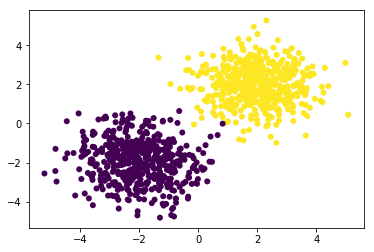

In [4]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [5]:
net = Sequential()
net.add(Linear(2, 2))
net.add(SoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(SoftMax())

Linear 2 -> 2
SoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [6]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [7]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

In [9]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

TypeError: unorderable types: NoneType() <= float()

# Digit classification 

We are using [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset. Lets start with [cool visualization](http://scs.ryerson.ca/~aharley/vis/). The most beautiful demo is the second one, if you are not familiar with convolutions you can return to it in several lectures. 

In [ ]:
import os
from sklearn.datasets import fetch_mldata

# Fetch MNIST dataset and create a local copy.
if os.path.exists('mnist.npz'):
    with np.load('mnist.npz', 'r') as data:
        X = data['X']
        y = data['y']
else:
    mnist = fetch_mldata("mnist-original")
    X, y = mnist.data / 255.0, mnist.target
    np.savez('mnist.npz', X=X, y=y)

One-hot encode the labels first.

In [ ]:
# Your code goes here. ################################################

- **Compare** `ReLU`, `ELU` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.

In [ ]:
# Your code goes here. ################################################

**Finally**, use all your knowledge to build a super cool model on this dataset, do not forget to split dataset into train and validation. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. 

In [ ]:
# Your code goes here. ################################################

Print here your accuracy. It should be around 90%.

In [ ]:
# Your answer goes here. ################################################

**Оформление дз**: заполните форму тут https://goo.gl/forms/Jx3OR5Ijjg2MwfKs2 
----------
**PS**: Напоминаем, что дедлайны жесткие, прием дз заканчивается ровно в дедлайн

# Bonus Part: Autoencoder 

This part is **OPTIONAL**, you may not do it. It will not be scored, but it is easy and interesting.

Now we are going to build a cool model, named autoencoder. The aim is simple: **encode** the data to a lower dimentional representation. Why? Well, if we can **decode** this representation back to original data with "small" reconstuction loss then we can store only compressed representation saving memory. But the most important thing is -- we can reuse trained autoencoder for classification. 
<img src="autoencoder.png">

Picture from this [site](http://multithreaded.stitchfix.com/blog/2015/09/17/deep-style/).

Now implement an autoencoder:

Build it such that dimetionality inside autoencoder changes like that: 

$$784 \text{ (data)} -> 512 -> 256 -> 128 -> 30 -> 128 -> 256 -> 512 -> 784$$

Use **MSECriterion** to score the reconstruction.

You may train it for 9 epochs with batch size = 256, initial lr = 0.1 droping by a factor of 2 every 3 epochs. The reconstruction loss should be about 6.0 and visual quality decent already.
Do not spend time on changing architecture, they are more or less the same. 

In [ ]:
# Your code goes here. ################################################

Some time ago NNs were a lot poorer and people were struggling to learn deep models. To train a classification net people were training autoencoder first (to train autoencoder people were pretraining single layers with [RBM](https://en.wikipedia.org/wiki/Restricted_Boltzmann_machine)), then substituting the decoder part with classification layer (yeah, they were struggling with training autoencoders a lot, and complex techniques were used at that dark times). We are going to this now, fast and easy.  

In [ ]:
# Extract inner representation for train and validation, 
# you should get (n_samples, 30) matrices
# Your code goes here. ################################################

# Now build a logistic regression or small classification net
cnet = Sequential()
cnet.add(Linear(30, 2))
cnet.add(SoftMax())

# Learn the weights
# Your code goes here. ################################################

# Now chop off decoder part
# (you may need to implement `remove` method for Sequential container) 
# Your code goes here. ################################################

# And add learned layers ontop.
autoenc.add(cnet[0])
autoenc.add(cnet[1])

# Now optimize whole model
# Your code goes here. ################################################

* What do you think, does it make sense to build real-world classifiers this way ? Did it work better for you than a straightforward one? Looks like it was not the same ~8 years ago, what has changed beside computational power? 

Run PCA with 30 components on the *train set*, plot original image, autoencoder and PCA reconstructions side by side for 10 samples from *validation set*.
Probably you need to use the following snippet to make aoutpencoder examples look comparible.

In [ ]:
# np.clip(prediction,0,1)
#
# Your code goes here. ################################################

In [1]:
import theano
import lasagne

1 #define _CUDA_NDARRAY_C
2 
3 #include <Python.h>
4 #include <structmember.h>
5 #include "theano_mod_helper.h"
6 
7 #include <numpy/arrayobject.h>
8 #include <iostream>
9 
10 #include "cuda_ndarray.cuh"
11 
12 #ifndef CNMEM_DLLEXPORT
13 #define CNMEM_DLLEXPORT
14 #endif
15 
16 #include "cnmem.h"
17 #include "cnmem.cpp"
18 
19 //If true, when there is a gpu malloc or free error, we print the size of allocated memory on the device.
20 #define COMPUTE_GPU_MEM_USED 0
21 
22 //If true, we fill with NAN allocated device memory.
23 #define ALLOC_MEMSET 0
24 
25 //If true, we print out when we free a device pointer, uninitialize a
26 //CudaNdarray, or allocate a device pointer
27 #define PRINT_FREE_MALLOC 0
28 
29 //If true, we do error checking at the start of functions, to make sure there
30 //is not a pre-existing error when the function is called.
31 //You probably need to set the environment variable
32 //CUDA_LAUNCH_BLOCKING=1, and/or modify the CNDA_THREAD_SYNC
33 //preprocessor macro 

1823             {
1824                 dim3 n_blocks(1, 1, 1);
1825                 dim3 n_threads(
1826                         std::min(
1827                             CudaNdarray_HOST_DIMS(self)[0],
1828                             NUM_VECTOR_OP_THREADS_PER_BLOCK));
1829                 k3<<<n_blocks, n_threads>>>(
1830                         1, //dimensions
1831                         1,
1832                         CudaNdarray_HOST_DIMS(self)[0],
1833                         CudaNdarray_DEV_DATA(self),
1834                         1, //strides
1835                         1,
1836                         CudaNdarray_HOST_STRIDES(self)[0],
1837                         CudaNdarray_DEV_DATA(other),
1838                         1, //strides
1839                         1,
1840                         other_strides[0]);
1841                 CNDA_THREAD_SYNC;
1842                 cudaError_t err = cudaGetLastError();
1843                 if (cudaSuccess != err)
1844                 

3446     if (CudaNdarray_alloc_contiguous((CudaNdarray*)rval, 2, dims))
3447     {
3448         goto CudaNdarray_dot_fail;
3449     }
3450     if (CudaNdarray_gemm(1.0, (CudaNdarray*)l, (CudaNdarray*)r, 0.0, (CudaNdarray*)rval))
3451     {
3452         goto CudaNdarray_dot_fail;
3453     }
3454 
3455     return rval;
3456 
3457     CudaNdarray_dot_fail:
3458     Py_XDECREF(rval);
3459     return NULL;
3460 }
3461 
3462 static PyObject *
3463 filter(PyObject* __unsed_self, PyObject *args) // args = (data, broadcastable, strict, storage)
3464 {
3465     /*
3466      * TODO: DOC what this function should do in the various cases of
3467      * What is 'strict' supposed to mean in the context of this function?
3468      * What do we do with input that could be interpreted as matching the broadcastable pattern in strict vs. non-strict cases?
3469      *
3470      */
3471     PyObject *py_data=NULL;
3472     PyArrayObject * data = NULL;
3473     int strict = 0;
3474     PyObject * broadcastab

5274     }
5275     return size;
5276 }
5277 
5278 PyObject *
5279 CudaNdarray_SIZE_Object(const CudaNdarray *self, void *closure)
5280 {
5281     return PyInt_FromLong(CudaNdarray_SIZE(self));
5282 }
5283 
5284 int CudaNdarray_set_device_data(CudaNdarray * self, float * data, const CudaNdarray * base)
5285 {
5286     return CudaNdarray_set_device_data(self, data, (PyObject *) base);
5287 }
5288 
5289 PyObject * CudaNdarray_IS_C_Contiguous(CudaNdarray * self)
5290 {
5291     return PyBool_FromLong(CudaNdarray_is_c_contiguous(self));
5292 }
5293 
5294 int fprint_CudaNdarray(FILE * fd, const CudaNdarray *self)
5295 {
5296     cudaError_t err = cudaGetLastError();
5297     if( cudaSuccess != err)
5298     {
5299         PyErr_Format(PyExc_RuntimeError,
5300                      "Cuda error: %s: %s.",
5301                      "fprint_CudaNdarray was called with an uncleared error",
5302                      cudaGetErrorString(err));
5303         return -1;
5304     }
5305     fprintf(fd, 


['nvcc', '-shared', '-O3', '-m64', '-Xcompiler', '-DCUDA_NDARRAY_CUH=mc72d035fdf91890f3b36710688069b2e,-DNPY_NO_DEPRECATED_API=NPY_1_7_API_VERSION,-fPIC,-fvisibility=hidden', '-Xlinker', '-rpath,/home/vlad/.theano/compiledir_Linux-4.8--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/cuda_ndarray', '-I/home/vlad/.local/lib/python3.5/site-packages/theano/sandbox/cuda', '-I/home/vlad/.local/lib/python3.5/site-packages/numpy/core/include', '-I/usr/include/python3.5m', '-I/home/vlad/.local/lib/python3.5/site-packages/theano/gof', '-L/usr/lib', '-o', '/home/vlad/.theano/compiledir_Linux-4.8--generic-x86_64-with-Ubuntu-16.04-xenial-x86_64-3.5.2-64/cuda_ndarray/cuda_ndarray.so', 'mod.cu', '-lcublas', '-lpython3.5m', '-lcudart']


ImportError: cannot import name 'downsample'